In this section we will take a look at Gaussian mixture models (GMMs), which can be viewed as an extension of the ideas behind k-means, but can also be a powerful tool for estimation beyond simple clustering

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

# Motivating GMM: Weakness of k-Means

if we have simple blobs of data, the k-means algorithm can quickly label those clusters in a way that closely matches what we might do by eye:

In [2]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

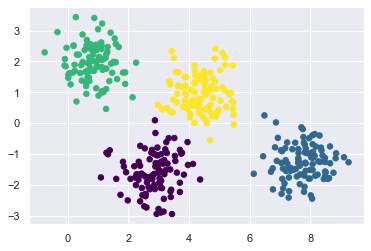

In [3]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=30, cmap='viridis');

Unfortunately, the k-means model has no intrinsic measure of probability or uncertainty of cluster assignments. For this, we must think about generalizing the model
<br>
One way to think about the k-means model is that it places a circle at the center of each cluster: any point outside this circle is not considered a member of the cluster

In [4]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    
    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=30, cmap='viridis',
               zorder=2, edgecolor='gray')
    
    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1,
                                edgecolor='gray'))

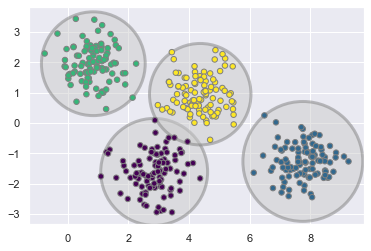

In [5]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

An important observation for k-means is that these cluster models must be circular
<br>
So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled

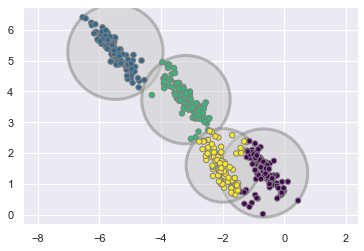

In [6]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

By eye, we recognize that these transformed clusters are non-circular, and thus circular clusters would be a poor fit
<br>
<br>
You might imagine allowing the cluster boundaries to be ellipse rather than circles, so as to account for non-circular clusters. It turns out these are two essential components of a different type of clustring model, Gaussian mixture models

# Generalizing E-M: Gaussian Mixture Models
<br>
A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset
<br>
<br>
In the simplest case, GMMs can be used for finding clusters in the smae manner as k-means

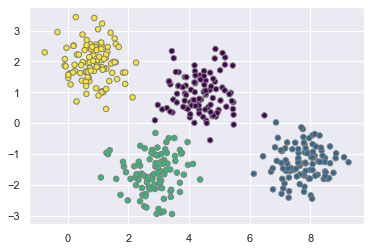

In [8]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=30, edgecolor='gray', cmap='viridis');

But because GMM contains a probabilistic model under the hood, it is also possible to find probabilist cluster assignment 
<br>
-> `predict_proba` method. This returns a matrix of size `[n_samples, n_clusters]`

In [9]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.537 0.463 0.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    1.    0.   ]]


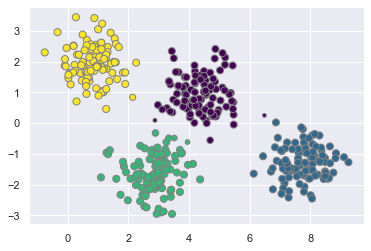

In [11]:
size = 50 * probs.max(1) ** 2 # square emphsize differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', edgecolor='gray', s=size);

Under the hood, a Gaussian mixture model is very similar to k-means: it uses an exprectation-maximization approach which qualitatively does the following:
1. Choose starting guesses for the location and shape
2. Repeat until converged:
    1. *E-step*: for each point, find weights encoding the probability of membership in each cluster
    2. *M-step*: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights

In [18]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principat axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
        
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=30, cmap='viridis',
                   zorder=2, edgecolor='gray')
    else:
        ax.scatter(X[:, 0], X[:, 1], s=30, zorder=2, edgecolor='gray')
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

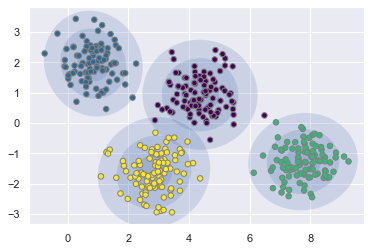

In [19]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

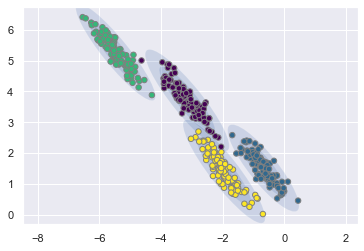

In [20]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

## Choosing the covariance type<br>
`covariance_type` option controls the degrees of freedom in the shape of each cluster<br><br>
The default is ~`covariance_type="diag"`~ -> changed to `covariance_type="full"`<br>
which allows each cluster to be modeled as an ellipse with arbitrary orientation

# GMM as Density Estimation <br>

The result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data

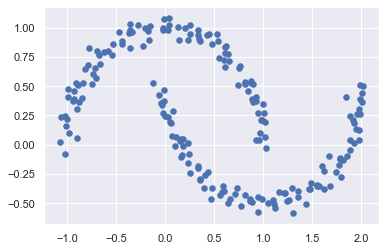

In [40]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1], s=30);

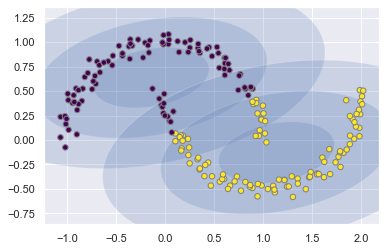

In [41]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

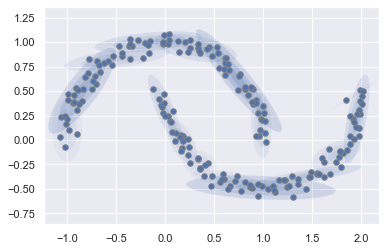

In [44]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

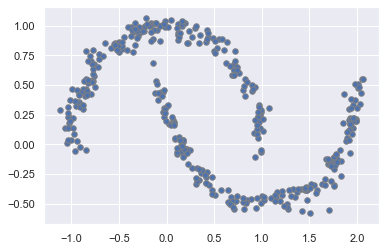

In [62]:
Xnew = gmm16.sample(400)
plt.scatter(Xnew[0][:, 0], Xnew[0][:, 1], s=30, edgecolor='gray');

## How many components? <br>
A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the *likelihood* of the data under the model, using cross-validation to avoid over-fitting <br><br>

Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the **Akaike information criterion (AIC)** or the **Bayesian information criterion (BIC)**

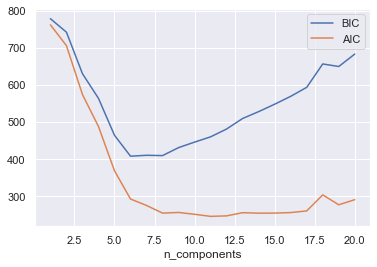

In [63]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]
plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

The optimal number of clusters is the value that minimizes the AIC or BIC <br><br>
I'd encourage you to think of GMM primarily as a density estimator, and use it for clustering only when warranted within simple datasets

# Example: GMM for Generating New Data

In [64]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

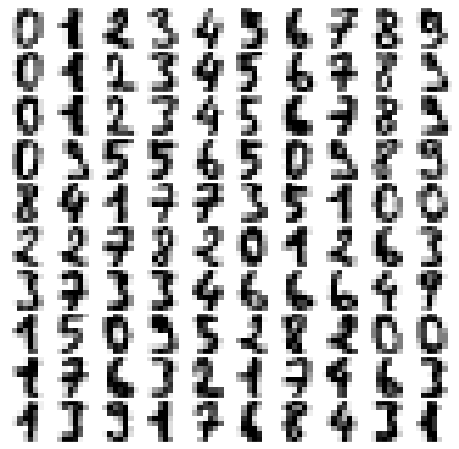

In [67]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

In [72]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

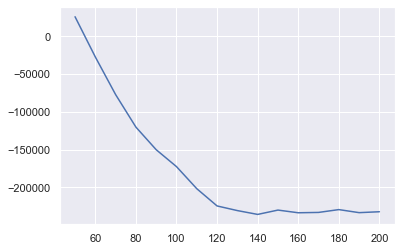

In [73]:
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

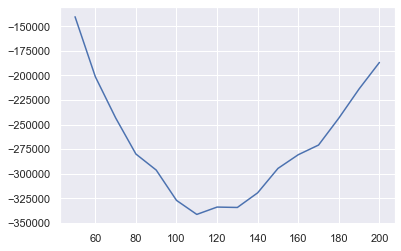

In [74]:
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(digits.data).aic(digits.data) for model in models]
plt.plot(n_components, aics);

In [75]:
gmm = GaussianMixture(110, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True
